In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import describe

import matplotlib.colors as colors

from scipy import signal

from scipy.stats import probplot
from scipy.stats import normaltest

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

from sklearn.metrics import mean_squared_error
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [2]:
# keras.backend.clear_session()
# gpus= tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)


In [3]:
def extract_features(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
#     amps /= 0.01
    amps = lin_log_interp(amps)
    
    _,minmax,mean,variance,skewness,kurtosis = describe(values,axis=1)
    mean = mean[...,np.newaxis]
    variance = variance[...,np.newaxis]
    skewness = skewness[...,np.newaxis]
    kurtosis = kurtosis[...,np.newaxis]
    
    sampleRMS = np.sqrt(1 / values.shape[0] * np.sum((values - np.repeat(mean,values.shape[1],axis=1).reshape(mean.shape[0],values.shape[1]))**2,axis=1))
    
    sampleRMS = sampleRMS[...,np.newaxis]
    
    print(mean.shape,variance.shape,skewness.shape,kurtosis.shape,sampleRMS.shape)
    stats = np.hstack((mean,variance,skewness,kurtosis,sampleRMS))
    
    return amps,stats


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [4]:
DoE_test = np.loadtxt('Experiment-3-Data/DoE_test_pruned.txt',delimiter=',')
DoE_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

X_train_original,stats_train_original = extract_features(X_train,)
X_test_original,stats_test_original = extract_features(X_test,)

stats_train_unhealthy = stats_train_original[first_good_train:,:]
stats_valid_unhealthy = stats_test_original[first_good_test:,:]
stats_train_healthy = stats_train_original[:first_good_train,:]
stats_valid_healthy = stats_test_original[:first_good_test,:]


X_train_unhealthy = X_train_original[first_good_train:,:]
X_valid_unhealthy = X_test_original[first_good_test:,:]
X_train_healthy = X_train_original[:first_good_train,:]
X_valid_healthy = X_test_original[:first_good_test,:]

DoE_train_healthy = DoE_train[:first_good_train,:]
DoE_train_unhealthy = DoE_train[first_good_train:,:]
DoE_test_healthy = DoE_test[:first_good_test,:]
DoE_test_unhealthy = DoE_test[first_good_test:,:]


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

stats_train = np.vstack((stats_train_healthy,stats_train_unhealthy))
stats_valid = np.vstack((stats_valid_healthy,stats_valid_unhealthy))

Y_train = XY_train[:,-1]
Y_valid = XY_valid[:,-1]
columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']

X = []
X.append(X_train_healthy)
X.append(X_valid_healthy)
X.append(X_train_unhealthy)
X.append(X_valid_unhealthy)

DoE = []
DoE.append(DoE_train_healthy)
DoE.append(DoE_test_healthy)
DoE.append(DoE_train_unhealthy)
DoE.append(DoE_test_unhealthy)

stats = []
stats.append(stats_train_healthy)
stats.append(stats_valid_healthy)
stats.append(stats_train_unhealthy)
stats.append(stats_valid_unhealthy)
freqs = np.linspace(0,10000,2048)


(306, 1) (306, 1) (306, 1) (306, 1) (306, 1)
(151, 1) (151, 1) (151, 1) (151, 1) (151, 1)


In [5]:
X_train_original.shape

(306, 2049)

In [6]:
def fit_statistics(y_true, y_pred):

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    # Null hypothesis: tool is healthy
    # Positive: Tool is unhealthy
    # Negative: Tool is healthy
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    
    # False positive: tool is actually healthy but classified as unhealthy
    # | - | X |
    # | - | - |
    false_positive = conf_matrix[0,1]
    
    # False negative: tool is actually unhealthy but classified as healthy
    # | - | - |
    # | X | - |
    false_negative = conf_matrix[1,0]
    
    # Precision: Quantifies false positives
    # Recall: Quantifies false negatives
    
    if true_positive == 0 and false_positive == 0.:
        precision = 0.
    else:
        precision = true_positive / (true_positive + false_positive)
    
    if true_positive == 0. and false_negative == 0.:
        recall = 0.
        true_positive_rate = 0.
    else:
        recall = true_positive / (true_positive + false_negative)
        true_positive_rate = true_positive / (true_positive + false_negative)

    if true_negative == 0. and false_positive == 0.:
        true_negative_rate = 0.
    else:
        true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
    
    return balanced_accuracy, true_positive_rate, true_negative_rate, precision, recall
 

def plot_confusion_matrix(y_true,y_pred,
                          labels,
                          filename='confusion_matrix'):
    
    predict_label = labels
    true_label = labels.copy()
    
    
    predict_label.insert(0, '')

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    # Null hypothesis: tool is healthy
    # Positive: Tool is unhealthy
    # Negative: Tool is healthy
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    
    # False positive: tool is actually healthy but classified as unhealthy
    # | - | X |
    # | - | - |
    false_positive = conf_matrix[0,1]
    
    # False negative: tool is actually unhealthy but classified as healthy
    # | - | - |
    # | X | - |
    false_negative = conf_matrix[1,0]
    
    # It is better to investigate something and conclude it is healthy
    # than let an unhealthy tool go unnoticed. For this reason, false
    # positives are considered less costly than false negatives
    
    # Precision: Quantifies false positives
    # Recall: Quantifies false negatives
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2

    fig = plt.figure()
    ax = plt.gca()
    im = ax.matshow(conf_matrix,cmap='gray',norm=colors.Normalize(vmin=0.,vmax=.5))

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(true_label)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(true_label)
    ax.set_yticklabels(predict_label)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ylabel = 'Actual State'
    xlabel = 'Predicted State'
    xlabelpad = 5

    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad)
    plt.ylabel(r'\textbf{' + ylabel + '}', labelpad=5)

    # Loop over data dimensions and create text annotations.
    for i in range(len(predict_label)-1):
        for j in range(len(true_label)):
            text_color = 'w'
            if conf_matrix[i,j] > 0.25:
                text_color = 'k'
            text = ax.text(j, i, r'\textbf{' + str(conf_matrix[i, j]) + '}',fontsize=22,
                           ha="center", va="center", color=text_color)

    cbar = plt.colorbar(im)
    cbar.set_label(r'\textbf{Occurrence Fraction}', rotation=270,labelpad=20)
    plt.tight_layout()
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    
    return balanced_accuracy, true_positive_rate, true_negative_rate, precision, recall

In [7]:
precision_recall = np.load('data/precision_recall_noscaling_noDoE.npy',allow_pickle=True)

In [8]:
train_precision = precision_recall[...,0]
train_recall = precision_recall[...,1]
valid_precision = precision_recall[...,2]
valid_recall = precision_recall[...,3]

train_score = 2 * np.nan_to_num((train_precision * train_recall) / (train_precision + train_recall))
valid_score = 2 * np.nan_to_num((valid_precision * valid_recall) / (valid_precision + valid_recall))

# train_score = np.sum(precision_recall[...,:2]**2,axis=-1)
# valid_score = np.sum(precision_recall[...,2:]**2,axis=-1)
combined_score = (valid_score)**2 + (train_score)**2
combined_score /= 2
freqs = np.linspace(0,10000,2048)

In [9]:
print(combined_score.flatten()[np.argmax(combined_score)])
print(train_score.flatten()[np.argmax(combined_score)])
print(valid_score.flatten()[np.argmax(combined_score)])
# print(np.argmax(combined_score))
# print(np.argmax(combined_score) % combined_score.shape[1])
# print(int(np.floor(np.argmax(combined_score) / combined_score.shape[1])))
# print(valid_score[29,np.argmax(combined_score) % combined_score.shape[1]])
# print(train_score[9,245])

best_pca = int(np.floor(np.argmax(combined_score) / combined_score.shape[1])) + 2
best_fft = np.argmax(combined_score) % combined_score.shape[1] + 2

print(best_pca)
print(best_fft)

0.9574669187145557
1.0
0.9565217391304347
31
301


In [10]:
pca = PCA(n_components=0.9)
pca.fit(np.hstack((XY_train[:,:512],DoE_train[:,:2])))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

In [11]:
pca.n_components_

135

ValueError: Failed to parse /usr/share/texlive/texmf-dist/fonts/enc/dvips/base/8r.enc as Postscript encoding

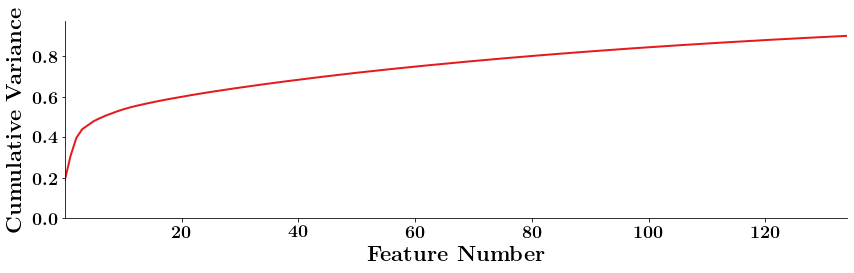

In [12]:
# combine the responses and labels to put on our 2D plot
responses = np.vstack((cumulative_variance))
labels = [r'']

# Create a 2D plot
genplt.generate_plot(np.arange(cumulative_variance.shape[0]), # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Feature Number',# X - axis label
              r'Cumulative Variance',   # Y - axis label
              filename='Test_PCA_Decomposition',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
              log_y=False,
              ymin=0.05,
              transparent=True,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='svg'
             )



In [13]:
def plot_scores(score,delta_f,filename='scores',template='publication'):
    
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()    
        
    yi = np.arange(-0.0, score.shape[0]) + 2
    xi = (np.arange(0.0,score.shape[1]) + 2) * delta_f

    X, Y = np.meshgrid(xi, yi)

#     plt.figure(figsize=(12,4))
    ax = plt.gca()
    plt.pcolormesh(X,Y,score,cmap='cividis',norm=colors.Normalize(vmin=np.amin(score),vmax=np.amax(score)))
    cbar = plt.colorbar()
    cbar.set_label(r'\textbf{Normalized Score}', rotation=270,labelpad=20)
    plt.ylabel(r'\textbf{PCA Dimensions}', labelpad=5,fontsize=22)
    plt.xlabel(r'\textbf{Spectral Bandwidth (Hz)}', labelpad=5,fontsize=22)
    
    plt.tight_layout(pad=1.2)
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    

def box_plot_compare(data,labels,legend,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=None,template='publication',
             xtickpad=5,showfliers=False,legend_loc='best',max_cutoff=0,min_cutoff=0,plot_type='violin'):
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
        
    position = [i+1 for i in range(len(data))]
    tickPositions = []
    phantomLines = []
        
    for i in range(data[0].shape[1]):
        
        thisData = [data[j][:,i] for j in range(len(data))]

        bp = plt.boxplot(thisData,
                        positions=position,
                        showfliers=showfliers,
                        patch_artist=True,
                        meanline=False,
                        notch=False,
                        medianprops={'color':'black',
                                     'linewidth':2},
                        whiskerprops={'linewidth':2},
                        capprops={'linewidth':2},
                        widths=0.75)

        for counter,patch in enumerate(bp['boxes']):
            # change outline color
            patch.set(color=colors[counter], linewidth=2)
            patch.set_facecolor(colors[counter])

            if i == 0:
                line, = plt.plot([1,1],color=colors[counter])
                phantomLines.append(line)
            
        tickPositions.append(np.mean(position))    
        position = [position[i] + len(data) + 1 for i in range(len(position))]
            
    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    ax.legend(tuple(phantomLines),tuple(legend),loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    [phantomLines[i].set_visible(False) for i in range(len(phantomLines))]
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    

In [14]:
[stats[0],stats[2]][0].shape

(156, 5)

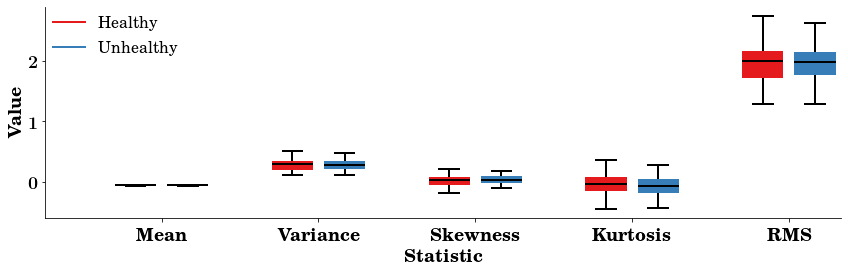

In [15]:
box_plot_compare([stats[0],stats[2]],['Mean','Variance','Skewness','Kurtosis','RMS'],['Healthy','Unhealthy'],savefig=True,filename='Time-Domain_Full-Compare',
         template='wide',xlabel='Statistic',color_order=np.zeros(6).astype(int),ylabel='Value',
         showfliers=False,legend_loc='upper left',max_cutoff=2,plot_type='box',
         log_y=False)

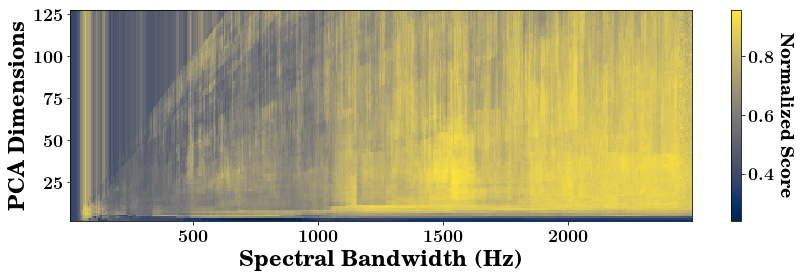

In [16]:
plot_scores(combined_score,freqs[1],filename='noDoE_Scores',template='wide')

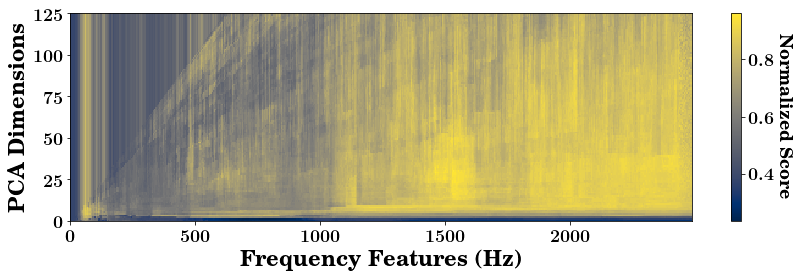

In [17]:
yi = np.arange(-0.0, valid_score.shape[0])
xi = np.arange(0.0,valid_score.shape[1])
xi = freqs[:valid_score.shape[1]]
X, Y = np.meshgrid(xi, yi)


plt.figure(figsize=(12,4))
ax = plt.gca()
plt.pcolormesh(X,Y,combined_score,cmap='cividis',norm=colors.Normalize(vmin=np.amin(combined_score),vmax=np.amax(combined_score)))
cbar = plt.colorbar()
cbar.set_label(r'\textbf{Normalized Score}', rotation=270,labelpad=20)
plt.ylabel(r'\textbf{PCA Dimensions}', labelpad=5,fontsize=22)
plt.xlabel(r'\textbf{Frequency Features (Hz)}', labelpad=5,fontsize=22)

plt.tight_layout(pad=1.2)

plt.show()

In [18]:
max_fft = best_fft
pca_components = best_pca
DoE_shape = 0
stats_shape = 0

X_train = np.hstack((XY_train[:,:max_fft],stats_train[:,:stats_shape],DoE_train[:,:DoE_shape]))
X_valid = np.hstack((XY_valid[:,:max_fft],stats_valid[:,:stats_shape],DoE_test[:,:DoE_shape]))
        
estimators = [('reduce_dim', PCA(n_components=pca_components)), ('gnb', GaussianNB())]

pipe = Pipeline(estimators)
pipe.fit(X_train,Y_train)

Y_valid_pred = pipe.predict(X_valid)
conf_matrix_valid = confusion_matrix(Y_valid, Y_valid_pred)
accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
print(conf_matrix_valid)
print(accuracy_valid)

Y_train_pred = pipe.predict(X_train)
conf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
accuracy_train = np.sum(np.diagonal(conf_matrix_train)) / np.sum(conf_matrix_train)
print(conf_matrix_train)
print(accuracy_train)

valid_stats = fit_statistics(Y_valid,Y_valid_pred)
train_stats = fit_statistics(Y_train,Y_train_pred)

print(valid_stats[-1]**2 + valid_stats[-2]**2)
print(train_stats[-1]**2 + train_stats[-2]**2)

print(valid_stats[-2],valid_stats[-1])

dump(pipe, 'data/pca_gnb.joblib') 

[[83  3]
 [ 4 61]]
0.9536423841059603
[[149   1]
 [  1 155]]
0.9934640522875817
1.830282820031701
2.0
0.9649122807017544 0.9482758620689655


['data/pca_gnb.joblib']

In [20]:
pipe.predict_proba(np.expand_dims(X_train[0,:],axis=0)).flatten()[0]

0.036545592283883946

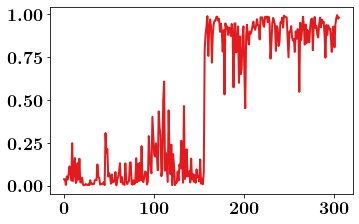

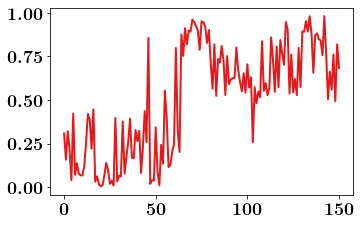

In [20]:
plt.plot(pipe.predict_proba(X_train_original[:,:max_fft + DoE_shape])[:,0])
plt.show()

plt.plot(pipe.predict_proba(X_test_original[:,:max_fft + DoE_shape])[:,0])
plt.show()

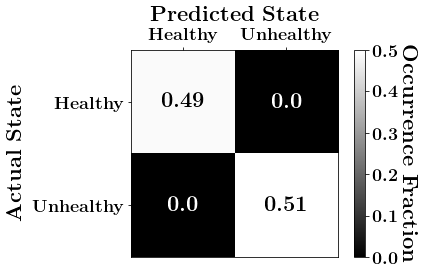

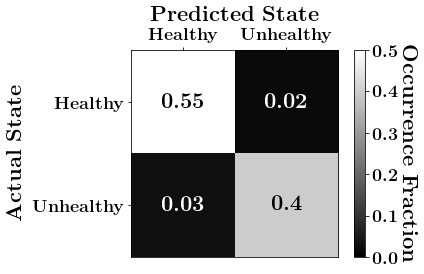

(1.0, 1.0, 1.0, 1.0, 1.0)
(0.9503284072249589, 0.9482758620689655, 0.9523809523809523, 0.9649122807017544, 0.9482758620689655)


In [21]:

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_valid'
                       )

print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [111]:
pca = pipe[0]
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_valid)

In [174]:
pca_train_error = np.zeros((best_pca,best_fft))
pca_test_error = np.zeros((best_pca,best_fft))

for i in range(best_pca):
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_valid)
    
    X_train_pca[:,i] = 0
    X_test_pca[:,i] = 0
    
    X_train_inv = pca.inverse_transform(X_train_pca)
    X_test_inv = pca.inverse_transform(X_test_pca)
    
    pca_train_error[i,:] = mean_squared_error(X_train_inv,X_train,multioutput='raw_values')
    pca_test_error[i,:] = mean_squared_error(X_test_inv,X_valid,multioutput='raw_values')

In [209]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_valid)

X_train_pca[:,3] = 0
X_train_pca[:,4] = 0
X_train_pca[:,6] = 0
X_train_pca[:,7] = 0

X_train_inv = pca.inverse_transform(X_train_pca)
X_test_inv = pca.inverse_transform(X_test_pca)


In [210]:
X_train_inv.shape

(306, 301)

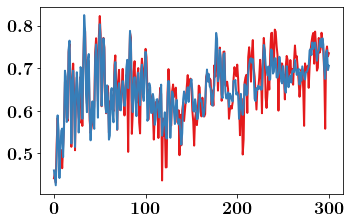

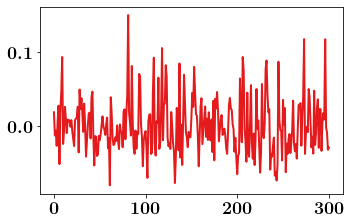

395.28


In [219]:
index = 100

plt.plot(X_train[index,:])
plt.plot(X_train_inv[index,:])
plt.show()

plt.plot(X_train_inv[index,:] - X_train[index,:])
plt.show()

print(np.argmax(X_train_inv[index,:] - X_train[index,:]) * 4.88)

In [220]:
X_train.shape

(306, 301)

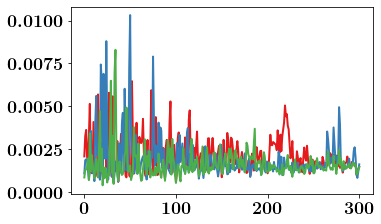

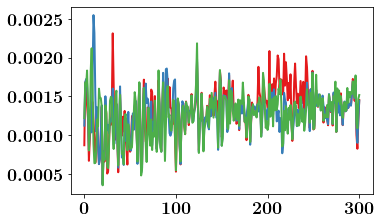

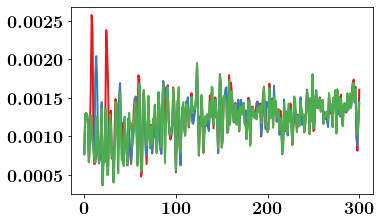

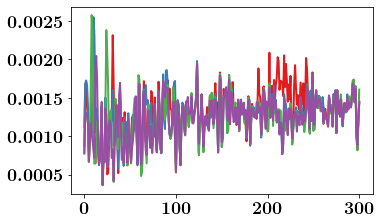

In [205]:
# plt.plot(pca_train_error[6,:])
# plt.plot(pca_train_error[3,:])
plt.plot(pca_train_error[0,:])
plt.plot(pca_train_error[1,:])
plt.plot(pca_train_error[2,:])
plt.show()

plt.plot(pca_train_error[3,:])
plt.plot(pca_train_error[4,:])
plt.plot(pca_train_error[5,:])
plt.show()

plt.plot(pca_train_error[6,:])
plt.plot(pca_train_error[7,:])
plt.plot(pca_train_error[8,:])
plt.show()

plt.plot(pca_train_error[3,:])
plt.plot(pca_train_error[4,:])
plt.plot(pca_train_error[6,:])
plt.plot(pca_train_error[7,:])
plt.show()

(301, 31)
(301, 31)
(301, 31)


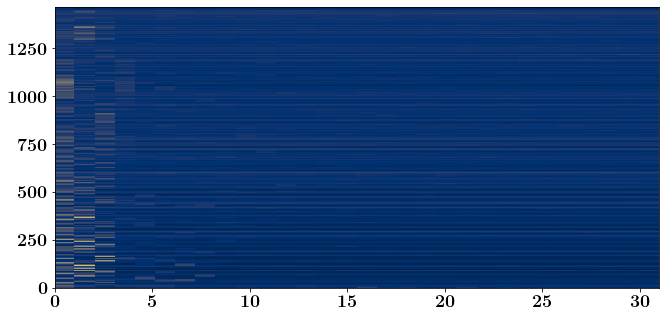

In [207]:
spectrogram = pca_train_error.T
# spectrogram = np.abs(X_valid - X_test_inv)
frequencyInterval = freqs[1]
size = (12,6)

yi = np.arange(-0.0, spectrogram.shape[0] * frequencyInterval,frequencyInterval)
xi = np.linspace(0.0,1,spectrogram.shape[1]) * spectrogram.shape[1]

X, Y = np.meshgrid(xi, yi)
plt.figure(figsize=(size))

print(X.shape)
print(Y.shape)
print(spectrogram.shape)

# Customize the axes
ax = plt.gca()
plt.pcolormesh(X,Y,spectrogram,cmap='cividis',norm=colors.Normalize(vmin=np.amin(spectrogram[:,:]),vmax=np.amax(spectrogram[:,:])))
plt.show()

In [140]:
print(pipe[1].sigma_)
print(pipe[1].theta_)

[[0.21323196 0.2132677  0.13217644 0.02407078 0.02020866 0.02380739
  0.02018195 0.01373851 0.01520601 0.01475734 0.01255085 0.00811761
  0.01100261 0.00953642 0.00709059 0.00655996 0.00754838 0.00831779
  0.00659231 0.00704772 0.00724226 0.00594814 0.0067747  0.00647333
  0.0066632  0.00622427 0.00567189 0.00629729 0.00565037 0.00638623
  0.00635305]
 [0.37509474 0.19922681 0.15083113 0.03315639 0.02934925 0.02946805
  0.0155988  0.01801487 0.01303859 0.01090009 0.01115939 0.01322988
  0.00817261 0.00916537 0.01030521 0.01068296 0.00866879 0.00713793
  0.00827116 0.00756317 0.00723222 0.00818795 0.00705893 0.00691815
  0.00607917 0.00636337 0.00656428 0.00588521 0.00612885 0.00525044
  0.00498012]]
[[-2.32579899e-02  5.40972862e-02  7.17987620e-03  1.18204129e-01
  -7.51412383e-02  4.16975485e-03 -6.02686381e-02 -3.80579835e-02
   1.16747871e-02 -2.32746400e-02 -2.00563204e-02 -9.49530849e-03
   3.10915165e-03 -5.95803939e-05 -9.27133822e-03  4.39122129e-04
   4.11619715e-03 -1.324594

In [141]:
mean_diff = np.abs(pipe[1].theta_[0,:] - pipe[1].theta_[1,:])

In [142]:
pipe[1].sigma_[0,:] / pipe[1].sigma_[1,:]

array([0.56847494, 1.07047692, 0.87632066, 0.72597705, 0.688558  ,
       0.80790509, 1.29381363, 0.76262031, 1.16623164, 1.3538726 ,
       1.12468928, 0.61358123, 1.34627811, 1.040484  , 0.68805901,
       0.6140586 , 0.87075387, 1.16529399, 0.79702416, 0.93184721,
       1.00138796, 0.72645041, 0.95973459, 0.93570295, 1.09607029,
       0.97813925, 0.86405319, 1.07001937, 0.92192941, 1.21632108,
       1.27568293])

In [143]:
normalized_sigma = pipe[1].sigma_[0,:] / pipe[1].sigma_[1,:]
normalized_theta = (pipe[1].theta_[0,:] - pipe[1].theta_[1,:]) / pipe[1].sigma_[1,:]

In [144]:
print(normalized_sigma)
print(normalized_theta)

[0.56847494 1.07047692 0.87632066 0.72597705 0.688558   0.80790509
 1.29381363 0.76262031 1.16623164 1.3538726  1.12468928 0.61358123
 1.34627811 1.040484   0.68805901 0.6140586  0.87075387 1.16529399
 0.79702416 0.93184721 1.00138796 0.72645041 0.95973459 0.93570295
 1.09607029 0.97813925 0.86405319 1.07001937 0.92192941 1.21632108
 1.27568293]
[-0.12162645  0.53262867  0.09337332  6.9929794  -5.02201633  0.27755937
 -7.57873811 -4.14392098  1.75636679 -4.18841358 -3.52539408 -1.407829
  0.74623874 -0.01275117 -1.7647468   0.08062886  0.93139644 -0.36400521
 -2.05190398 -0.0988846   0.71975954 -0.10204503  1.6601504   0.45448831
  2.14605389  0.78242603 -0.90438496  0.39660392 -0.39143486  1.485237
  0.02427203]


In [153]:
best_pca
best_fft

301

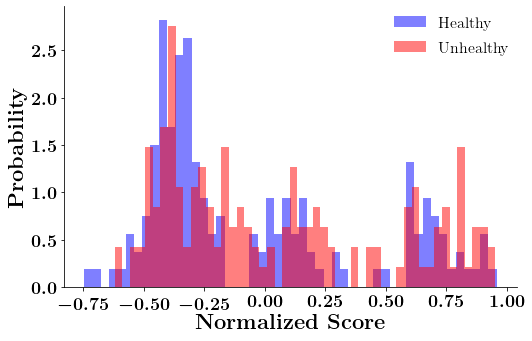

In [188]:
index_number = 1

num_col = 1
legend_loc = 'best'
transparent=True
plt.figure(figsize=(9,6))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(X_train_pca[np.argwhere(Y_train == 1).flatten(),index_number], 50, density=True, facecolor='b', alpha=0.50,label='Healthy')
# n, bins, patches = plt.hist(norm_scores[1], 50, density=True, facecolor='r', alpha=0.50,label='Valid')
n, bins, patches = plt.hist(X_train_pca[np.argwhere(Y_train == 0).flatten(),index_number], 50, density=True, facecolor='r', alpha=0.50,label='Unhealthy')
# n, bins, patches = plt.hist(norm_scores[3], 50, density=True, facecolor='c', alpha=0.50,label='Anomalous Valid')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Normalized Score}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
# plt.savefig('figures/Spindle_Load_Anomalous_Compare-Healthy_Unhealthy.svg',transparent=True)     
plt.show()

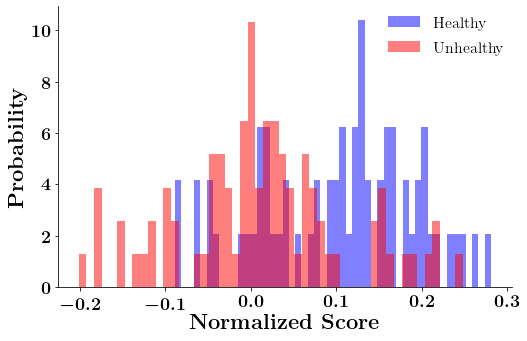

In [151]:
index_number = 6

num_col = 1
legend_loc = 'best'
transparent=True
plt.figure(figsize=(9,6))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(X_test_pca[np.argwhere(Y_valid == 1).flatten(),index_number], 50, density=True, facecolor='b', alpha=0.50,label='Healthy')
# n, bins, patches = plt.hist(norm_scores[1], 50, density=True, facecolor='r', alpha=0.50,label='Valid')
n, bins, patches = plt.hist(X_test_pca[np.argwhere(Y_valid == 0).flatten(),index_number], 50, density=True, facecolor='r', alpha=0.50,label='Unhealthy')
# n, bins, patches = plt.hist(norm_scores[3], 50, density=True, facecolor='c', alpha=0.50,label='Anomalous Valid')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Normalized Score}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
# plt.savefig('figures/Spindle_Load_Anomalous_Compare-Healthy_Unhealthy.svg',transparent=True)     
plt.show()